# Dynamic Programming, Frozen Lake

In [1]:
import sys
from six import StringIO, b
from contextlib import closing

import numpy as np
from gym import utils
from gym.envs.toy_text import discrete

In [2]:
import numpy as np
import copy

import check_test
from utils import plot_values
from frozenlake import FrozenLakeEnv

## Explore The Environment

In [3]:
env = FrozenLakeEnv(map_name="4x4", is_slippery=True)

In [4]:
print('Environment Display:')
env.render()

Environment Display:

SFFF
FHFH
FFFH
HFFG


In [5]:
# print the state space and action space
print('State space:', env.observation_space)
print('Action space:', env.action_space)

State space: Discrete(16)
Action space: Discrete(4)


In [6]:
# print the total number of states and actions
print('Total number of states', env.nS)
print('Total number of actions', env.nA)

Total number of states 16
Total number of actions 4


In [7]:
# look at one-step dynamics (in is_slippery=True)
prob, next_state, reward, done = env.P[0][2][1] # 0 means state (starting point) and 2 means action RIGHT
print(f'Probabiltiy: {prob:.2f}')
print('Next state:', next_state)
print('Reward:', reward)
print('Done:', done)

Probabiltiy: 0.33
Next state: 1
Reward: 0.0
Done: False


## 1. Set Iterative Policy Evaluation

In [8]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    
    # V denotes the most recent guess for the state-value function
    V = np.zeros(env.nS)
    while True:
        
        delta = 0
        for s in range(env.nS):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for transition_prob, next_state, reward, done in env.P[s][a]:
                    # apply Bellman Expectation Equation as (synchronous) update rule
                    Vs += action_prob * transition_prob * (reward + gamma * V[next_state])
                    
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V

Random Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):


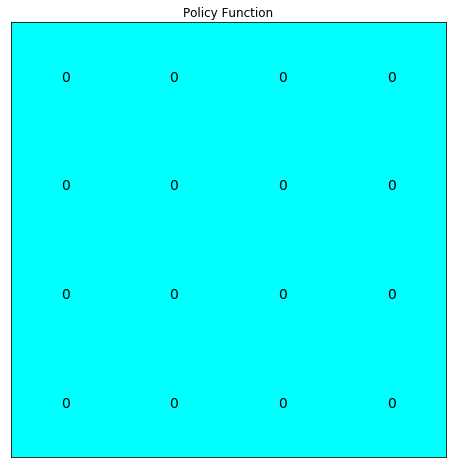

In [9]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
print("Random Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
plot_values(np.reshape(np.argmax(random_policy, axis=1), (4,4)), name='Policy', shape=(4,4))

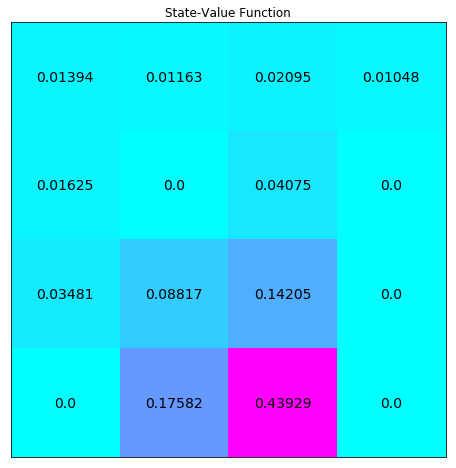

In [10]:
# evaluate the policy
V = policy_evaluation(env, random_policy)
plot_values(V, name='State-Value', shape=(4,4))

In [11]:
check_test.run_check('policy_evaluation_check', policy_evaluation)

**<span style="color: green;">PASSED</span>**

## 2. Obtan Q-value ($q_\pi$) from V-value ($v_\pi$)

In [12]:
def q_from_v(env, V, s, gamma=1):
    
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for transition_prob, next_state, reward, done in env.P[s][a]:
            q[a] += transition_prob * (reward + gamma * V[next_state])
        
    return q

In [13]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
    
print('Action-Value Function:')
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


In [14]:
check_test.run_check('q_from_v_check', q_from_v)

**<span style="color: green;">PASSED</span>**

## 3. Set Policy Improvement

In [15]:
def policy_improvement(env, V, gamma=1):
    
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        
        q = q_from_v(env, V, s, gamma)
        
        # OPTION 1: construct a deterministic policy
        # policy[s][np.argmax(q)] = 1
        
        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten() # greedy policy improvement
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0) / len(best_a)
    
    return policy

In [16]:
check_test.run_check('policy_improvement_check', policy_improvement)

**<span style="color: green;">PASSED</span>**

## 4. Set Policy Iteration

In [17]:
def policy_iteration(env, gamma=1, theta=1e-8): # smaller theta it will take longer
    
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V)
        
        # option 1: stop if the policy is unchanged after an improvement step
        # if (new_policy == policy).all():
            # break;
            
        # option 2: stop if the value function estimates for successive policies has converged
        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2:
            break
            
        policy = copy.copy(new_policy)
    return policy, V

In [18]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):


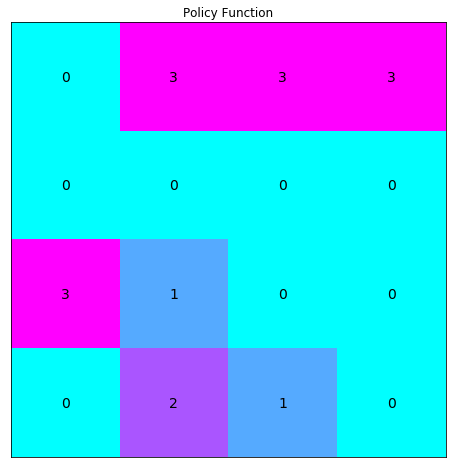

In [19]:
# print the optimal policy
print("Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
plot_values(np.reshape(np.argmax(policy_pi, axis=1), (4,4)), name='Policy', shape=(4,4))

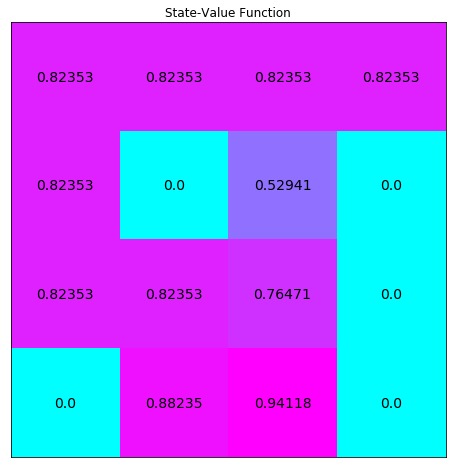

In [20]:
plot_values(V_pi, name='State-Value', shape=(4,4))

In [21]:
check_test.run_check('policy_iteration_check', policy_iteration)

**<span style="color: green;">PASSED</span>**

## 5. Set Truncated Policy Iteration

In [22]:
def truncated_policy_evaluation(env, policy, V, max_iteration=1, gamma=1):
    
    num_iteration = 0
    while num_iteration < max_iteration:
        for s in range(env.nS):
            
            v = 0
            q = q_from_v(env, V, s, gamma)
            for a, action_prob in enumerate(policy[s]):
                v += action_prob * q[a]
            V[s] = v
        num_iteration += 1
    return V

In [23]:
def truncated_policy_iteration(env, max_iteration=1, gamma=1, theta=1e-8):
    
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA]) / env.nA
    while True:
        policy = policy_improvement(env, V)
        old_V = copy.copy(V)
        V = truncated_policy_evaluation(env, policy, V, max_iteration, gamma)
        if max(abs(V-old_V)) < theta:
            break
            
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):


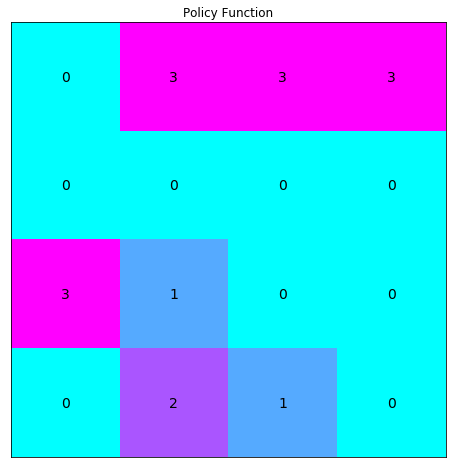

In [24]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_iteration=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
plot_values(np.reshape(np.argmax(policy_tpi, axis=1), (4,4)), name='Policy', shape=(4,4))

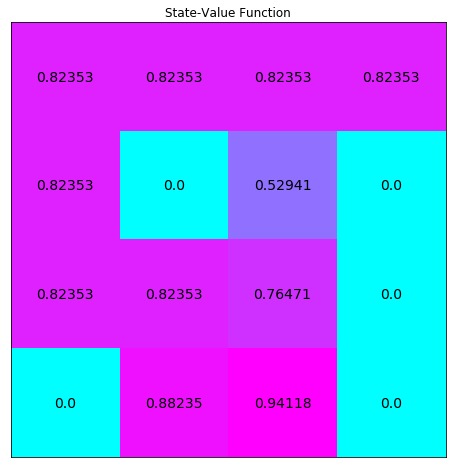

In [25]:
# plot the optimal state-value function
plot_values(V_tpi, name='State-Value', shape=(4,4))

In [26]:
check_test.run_check('truncated_policy_iteration_check', truncated_policy_iteration)

**<span style="color: green;">PASSED</span>**

## 6. Set Value Iteration

In [27]:
def value_iteration(env, gamma=1, theta=1e-8):
    
    V = np.zeros(env.nS)
    while True:
        
        delta = 0
        for s in range(env.nS):
            
            v = V[s]
            # apply Bellman Optimality Equation
            V[s] = max(q_from_v(env, V, s, gamma))
            delta = max(delta, abs(V[s]-v))
        if delta < theta:
            break
    
    policy = policy_improvement(env, V, gamma)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):


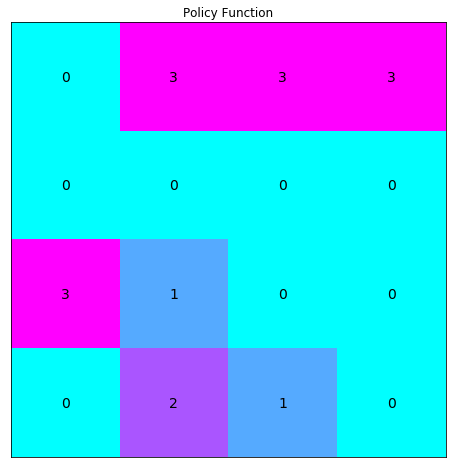

In [28]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
plot_values(np.reshape(np.argmax(policy_tpi, axis=1), (4,4)), name='Policy', shape=(4,4))

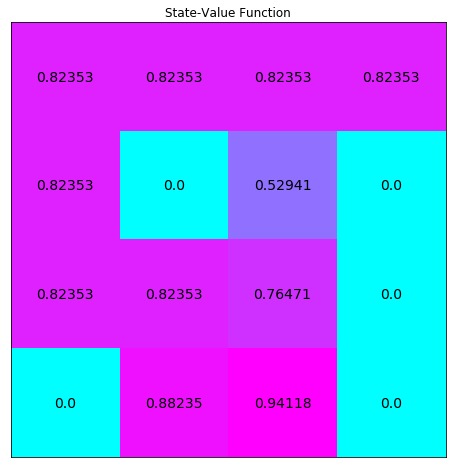

In [29]:
# plot the optimal state-value function
plot_values(V_vi, name='State-Value', shape=(4,4))

In [30]:
check_test.run_check('value_iteration_check', value_iteration)

**<span style="color: green;">PASSED</span>**

## Time To Play!

In [31]:
def play_frozen_lake(env, n_episodes, policy):
    
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
        
        terminated = False
        state = env.reset()
        while not terminated:
            # select best action to perform in a current state
            action = np.argmax(policy[state])
            
            # perform an action an observe how environment acted in response
            next_state, reward, terminated, _ = env.step(action)
            
            # summarize total reward
            total_reward += reward
            
            # update the current state
            state = next_state
            
            # calculate number of wins over episodes
            if terminated and reward == 1.0:
                wins += 1
        
    average_reward = total_reward / n_episodes
    return wins, total_reward, average_reward

In [32]:
# number of episodes to play
n_episodes = 20000

# functions to find best policy
solvers = [('Policy Iteration', policy_iteration),
           ('Value Iteration', value_iteration)]

In [33]:
for iteration_name, iteration_function in solvers:
    
    # load a Frozen Lake environment
    env = FrozenLakeEnv(map_name="4x4", is_slippery=True)
    
    # search for an optimal policy using the iteration function defined
    optimal_policy, optimal_V = iteration_function(env)
    
    # apply the optimal policy to the real environment
    print(f'Playing with {iteration_name}...')
    wins, total_reward, average_reward = play_frozen_lake(env, n_episodes, optimal_policy)
    
    print(f'{iteration_name}: number of wins over {n_episodes} episodes = {wins}')
    print(f'{iteration_name}: average reward over {n_episodes} episodes = {average_reward} \n')

Playing with Policy Iteration...
Policy Iteration: number of wins over 20000 episodes = 16435
Policy Iteration: average reward over 20000 episodes = 0.82175 

Playing with Value Iteration...
Value Iteration: number of wins over 20000 episodes = 16492
Value Iteration: average reward over 20000 episodes = 0.8246 



---